# Using Image Pyramid for Image Blending

Image pyramids refers to the way of representing an image at multiple resolutions. Some features may detected better at some other resolutions.

Imports

In [1]:
import cv2
import numpy as np
from PIL import Image

Reading images

In [2]:
def read_image(sn,tn):
    source = cv2.imread('blend/source/'+sn+'.jpg')
    source = cv2.cvtColor(source, 1) 
    target = cv2.imread('blend/target/'+tn+'.jpg')
    target = cv2.cvtColor(target, 1)
    return source, target

##### Calculating Gaussian Pyramid

Gaussian pyramid involves applying repeated Gaussian downsampling and blurring an image until stopping criteria are met. For our code stopping criteria is number of levels. gaussian_pyramid() function calculates and stores number of images, pyramid level we choose

In [3]:
def gaussian_pyramid(img, pyramid_level):
    #find gaussian pyramids
    lower = img.copy()
    g_pyramid = [lower]
    for i in range(pyramid_level):
        lower = cv2.pyrDown(lower)
        g_pyramid.append(np.float32(lower))
    return g_pyramid

###### Calculating Laplacian Pyramid

Laplacian is a simply a high-pass filter. So at each level of pyramid, we will get an edge image. We can approximate Laplacian using differences of Gaussians

In [4]:
def laplacian_pyramid(gaussian_pyr):
    #calculate the laplacians
    laplacian_top = gaussian_pyr[-1]
    pyramid_level = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(pyramid_level,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr

###### Blending two images

Now we can blend images acording to mask images. 

In [5]:
def blend(laplacian_input ,laplacian_target, mask_pyr):
    #blend two images
    LS = []
    for li, lt, mask in zip(laplacian_input, laplacian_target, mask_pyr):
        ls = lt * mask + li * (1.0 - mask)
        #print(ls)
        LS.append(ls)
    return LS

###### Reconstruction

We can reconstruct image by expanding the level and adding it to the below level.

In [6]:
def reconstruct(laplacian_pyramid):
    #get the original image 
    laplacian_top = laplacian_pyramid[0]
    laplacian_lst = [laplacian_top]
    pyramid_level = len(laplacian_pyramid) - 1
    for i in range(pyramid_level):
        size = (laplacian_pyramid[i + 1].shape[1], laplacian_pyramid[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyramid[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

Now we will combine everything we done so far and create the blended image

In [7]:
# image names
sources = ['sky','snow','wall','sea','desert','ball_s']
targets = ['jet','snowboard','window','boat','motorcycle','ball_t']
# mask coordinates
masks = [[215,810,380,960],[473,733,380,488],[230,561,980,1140],[160,665,370,570],[380,600,1047,1310],[460,755,1000,1300]]

def blend_images(pyramid_level):
    
    for n in range(len(sources)):
        print("Blending picture "+ str(n+1) + "...")
        img1, img2 = read_image(sources[n],targets[n])

        # create the mask
        mask = np.zeros((1000, 1600,3), dtype='float32')
        mask[masks[n][0]:masks[n][1],masks[n][2]:masks[n][3],:] = (1,1,1)
        
        
        if(n == 4): # improved mask shape for motorcycle photo
            
            mask[380:530,1170:1310,:] = np.tril(np.ones((3,150,140))).transpose(1, 2, 0)
            rotated_mask = np.rot90(mask[380:510,1047:1130,:])
            rotated_mask = np.triu(np.ones((3,83,130))).transpose(1, 2, 0) 
            mask[380:510,1047:1130,:] = np.rot90(rotated_mask,3)

        img = Image.fromarray((mask * 255).astype(np.uint8))
        display(img) # displaying mask

        # calculate Gaussian and Laplacian for img1
        gaussian_input = gaussian_pyramid(img1, pyramid_level)
        laplacian_input = laplacian_pyramid(gaussian_input)
        
        # calculate Gaussian and Laplacian for img2
        gaussian_target = gaussian_pyramid(img2, pyramid_level)
        laplacian_target = laplacian_pyramid(gaussian_target)
        
        # calculate the Gaussian pyramid for the mask image and reverse it.
        mask_pyramid = gaussian_pyramid(mask, pyramid_level)
        mask_pyramid.reverse()
        
        # blend the images
        add_laplace = blend(laplacian_input,laplacian_target,mask_pyramid)
        
        # reconstruct the images
        result = reconstruct(add_laplace)
        
        # save images
        cv2.imwrite('blend/results/result'+str(n+1)+'.jpg', result[pyramid_level])
        cv2.imwrite('blend/masks/mask'+str(n+1)+'.jpg', (mask * 255).astype(np.uint8))

        

Blending picture 1...


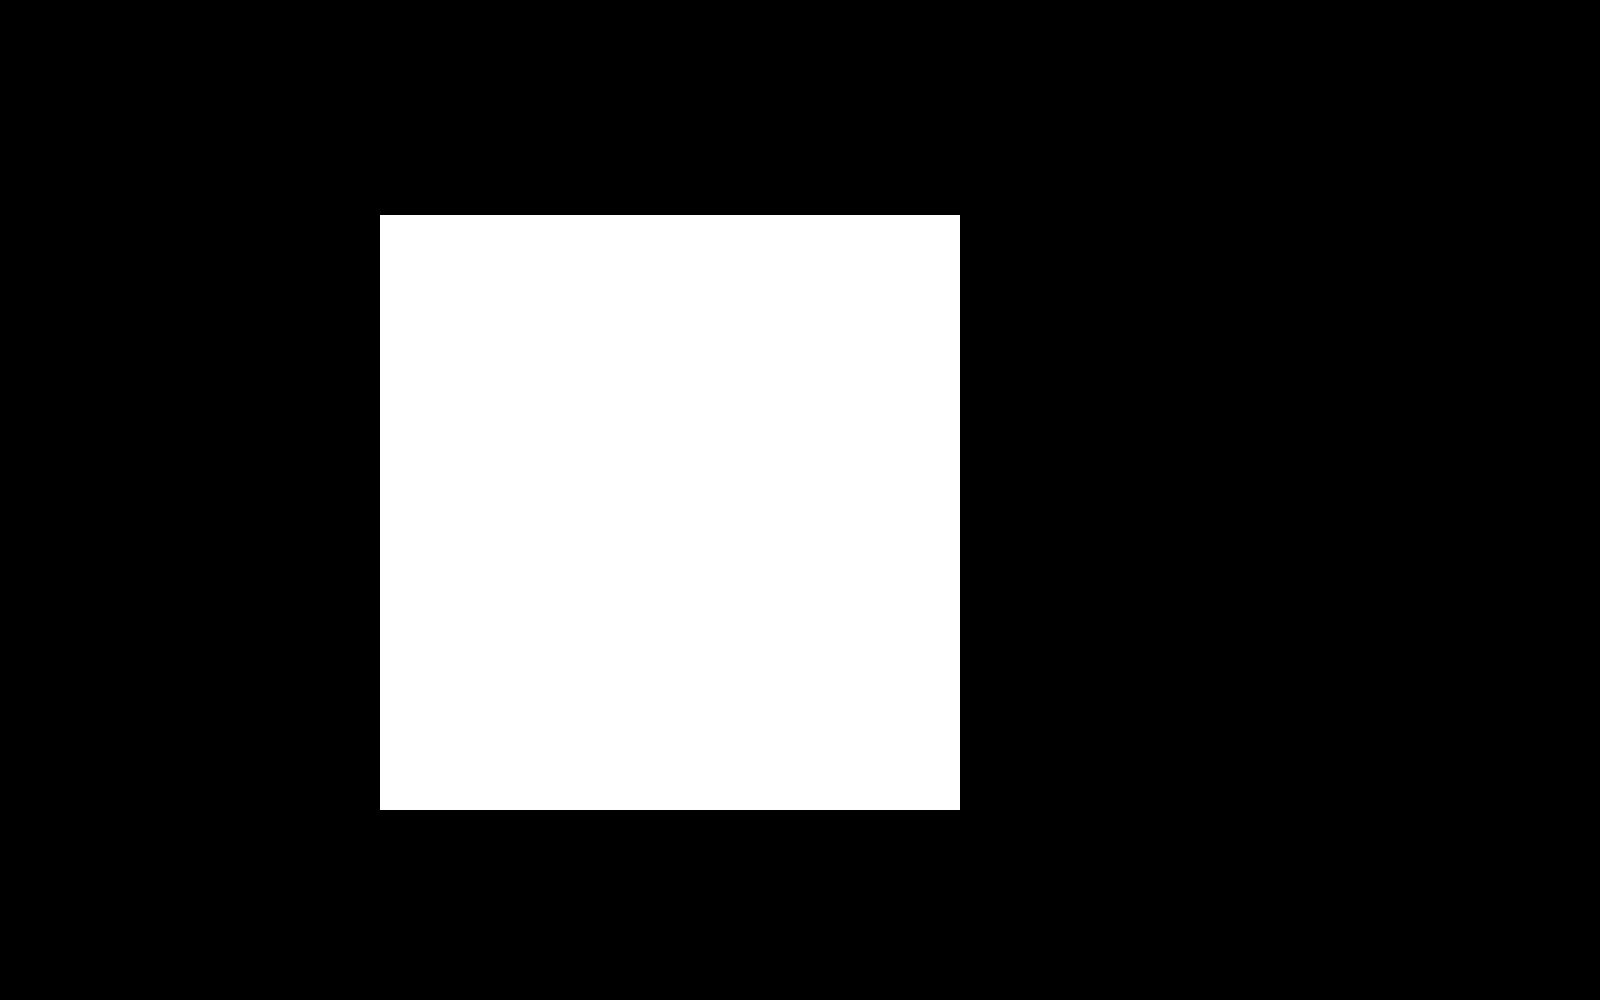

Blending picture 2...


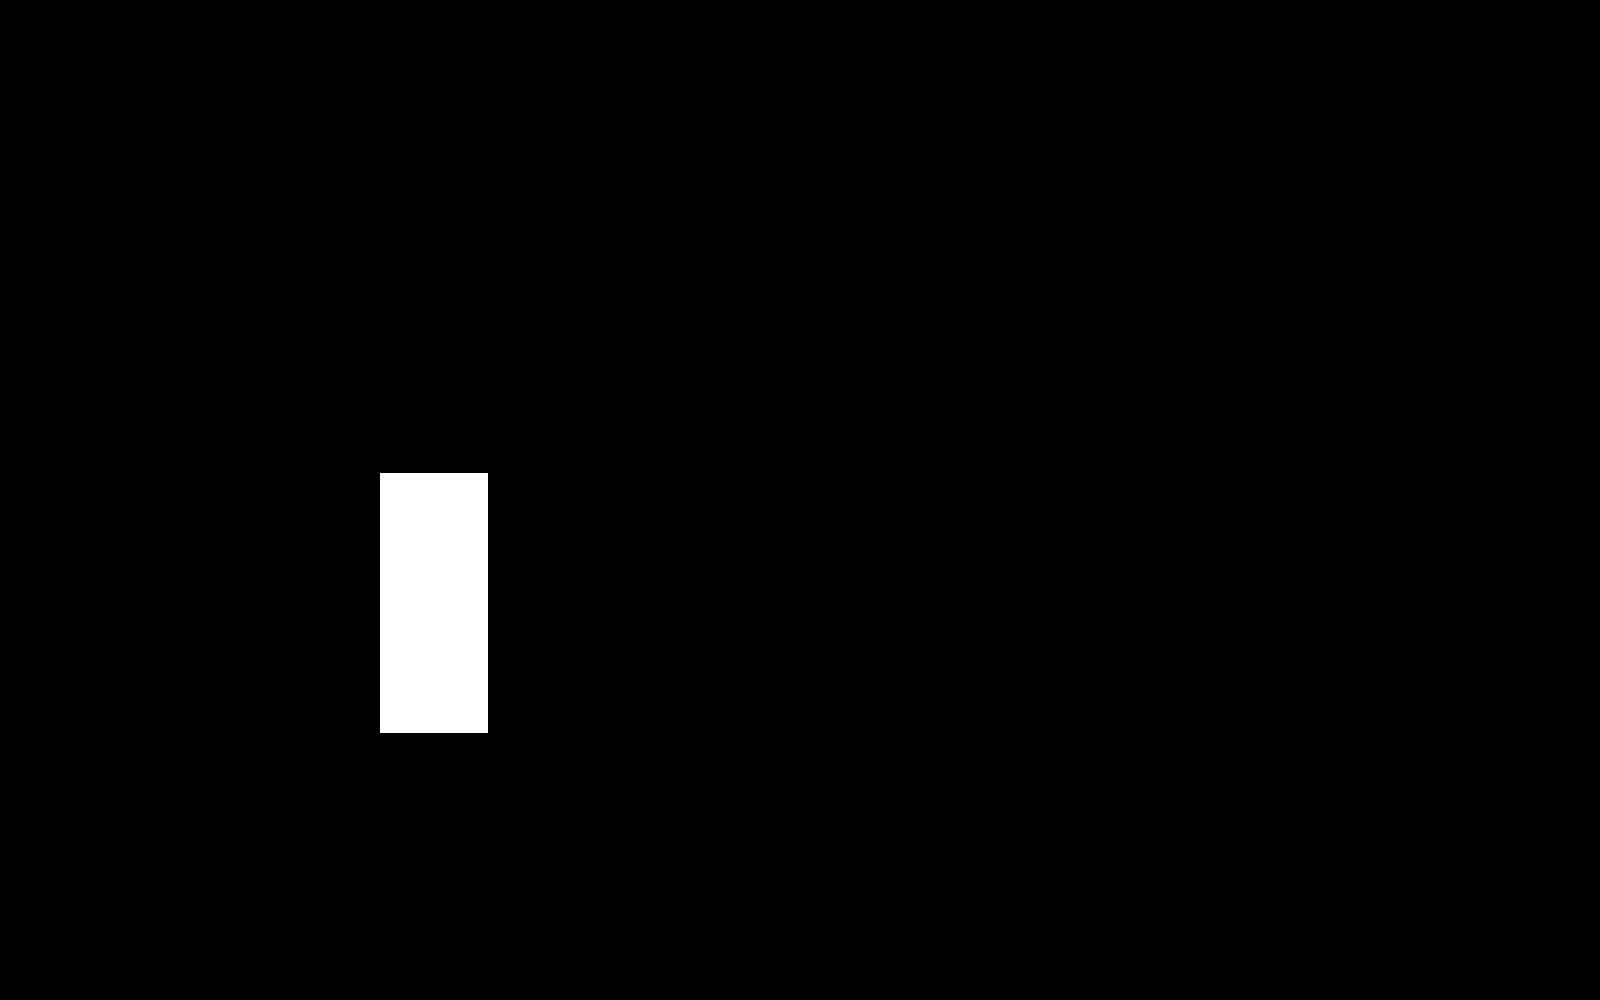

Blending picture 3...


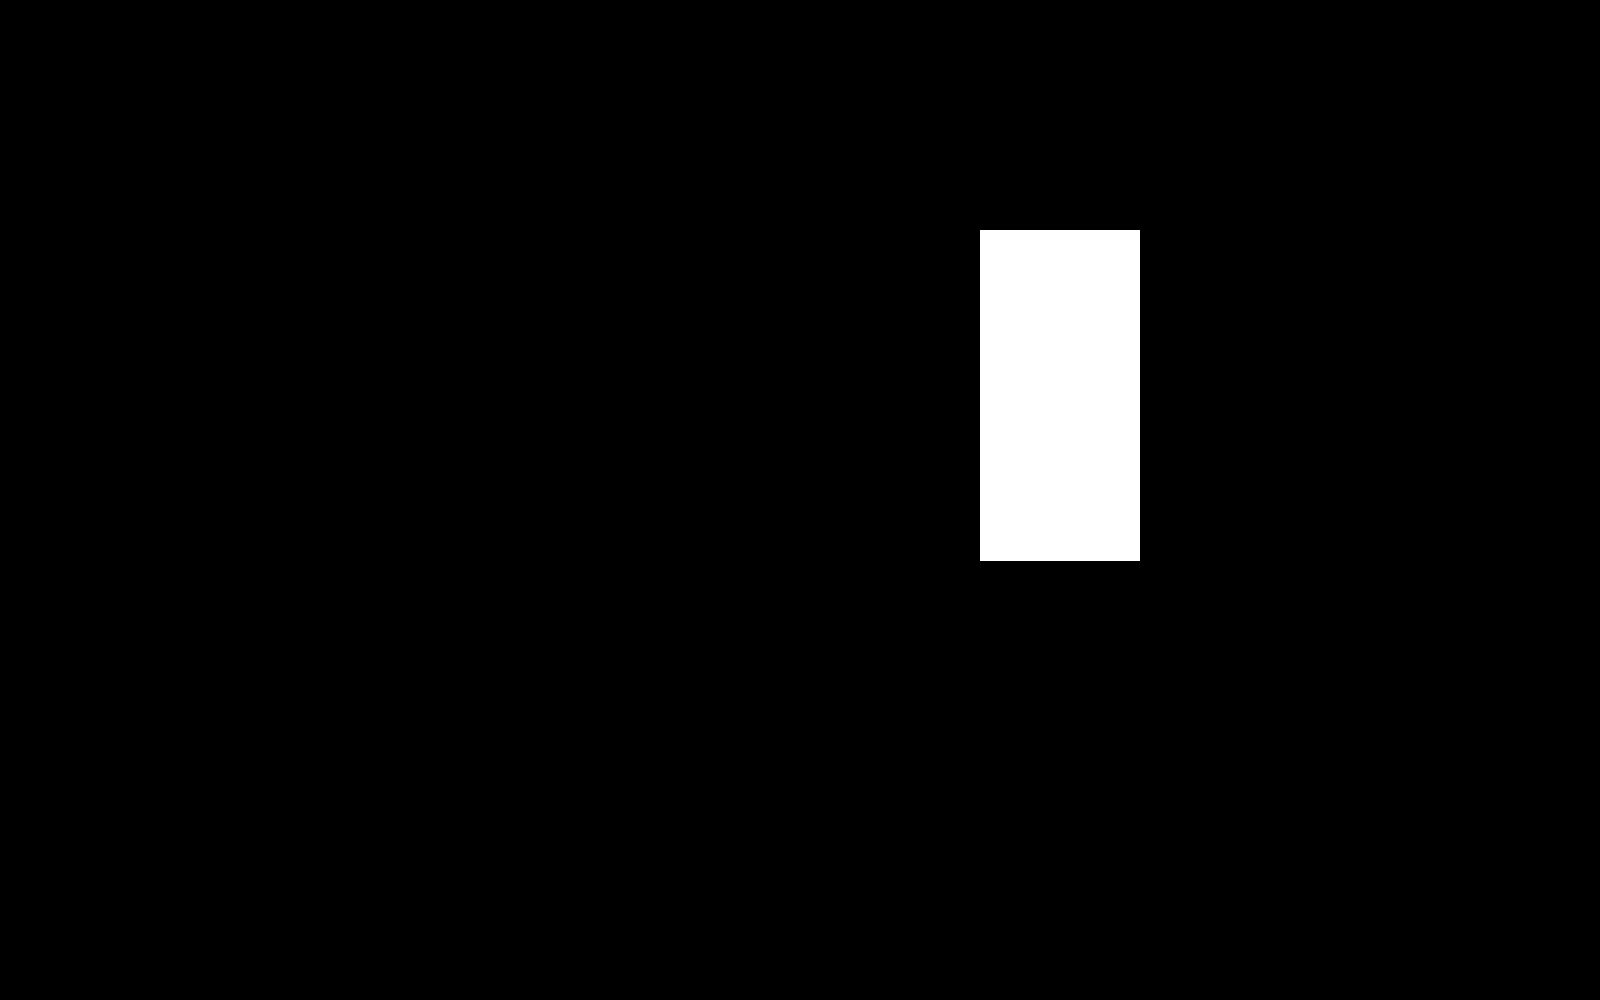

Blending picture 4...


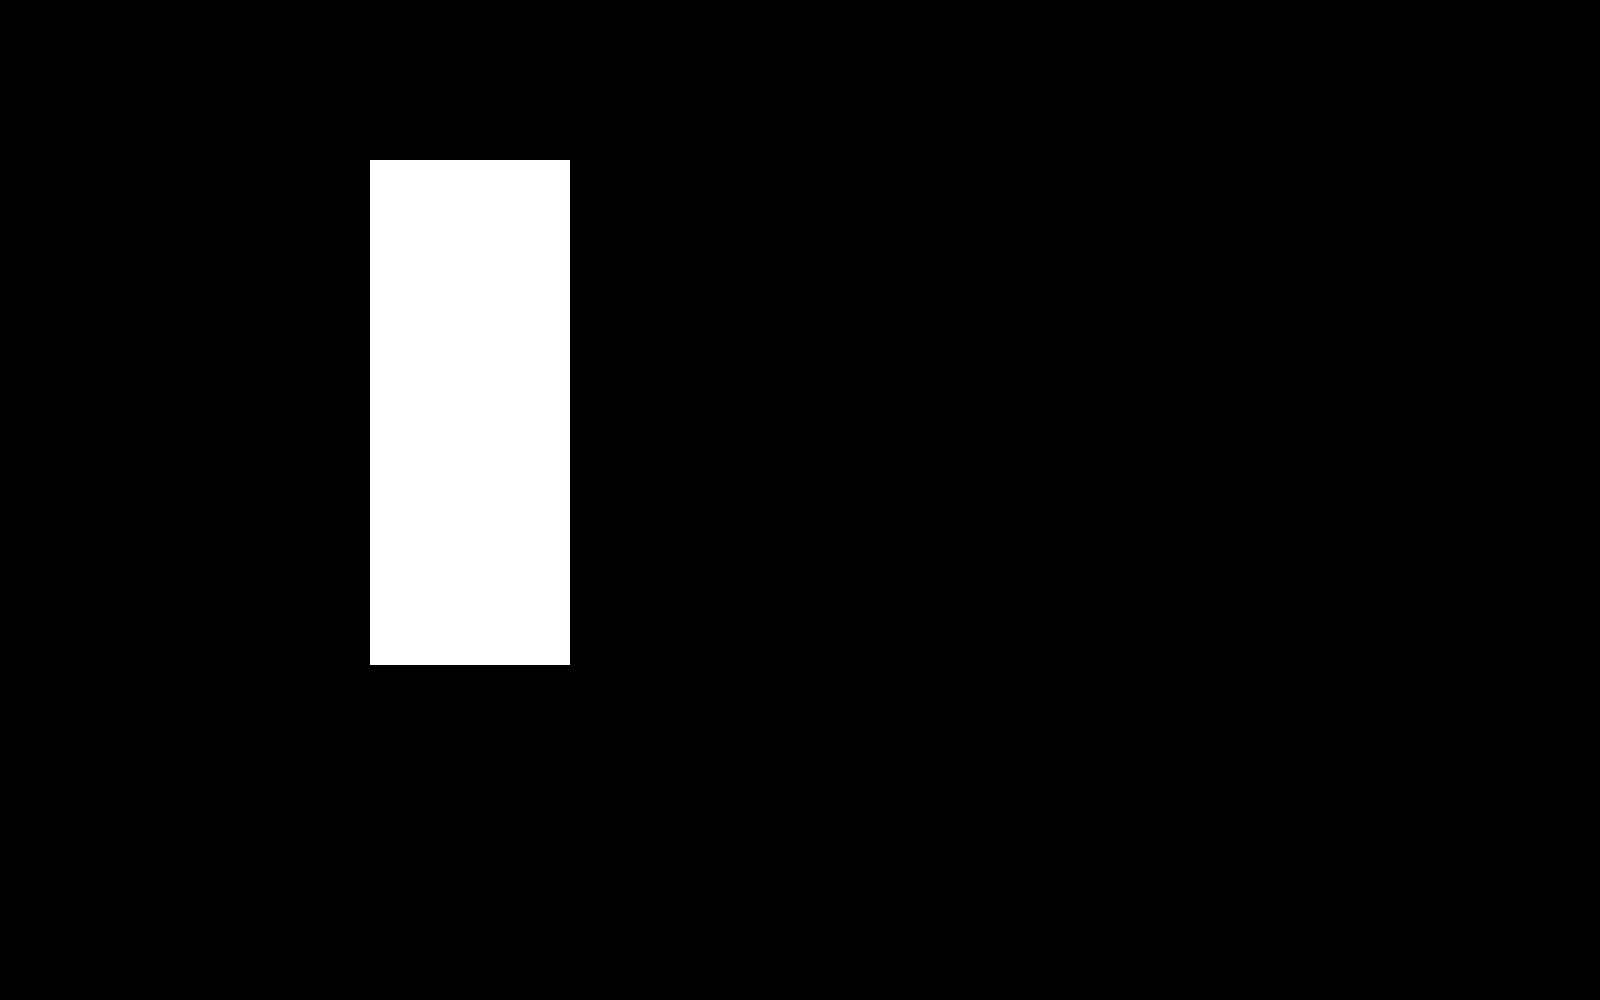

Blending picture 5...


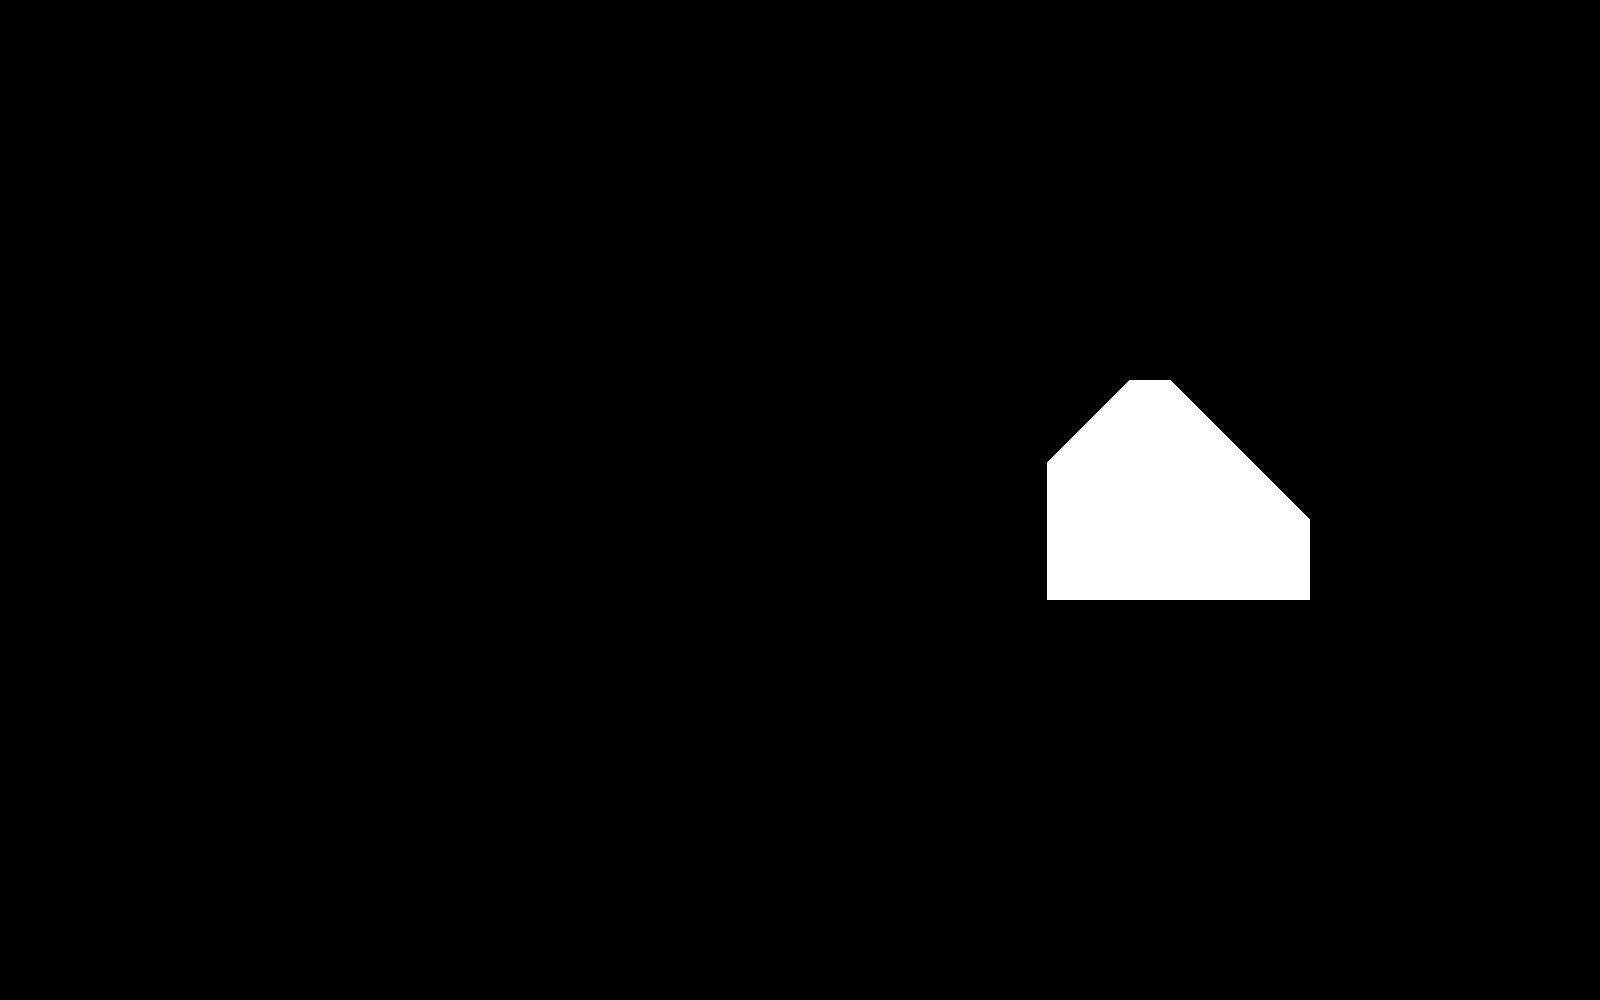

Blending picture 6...


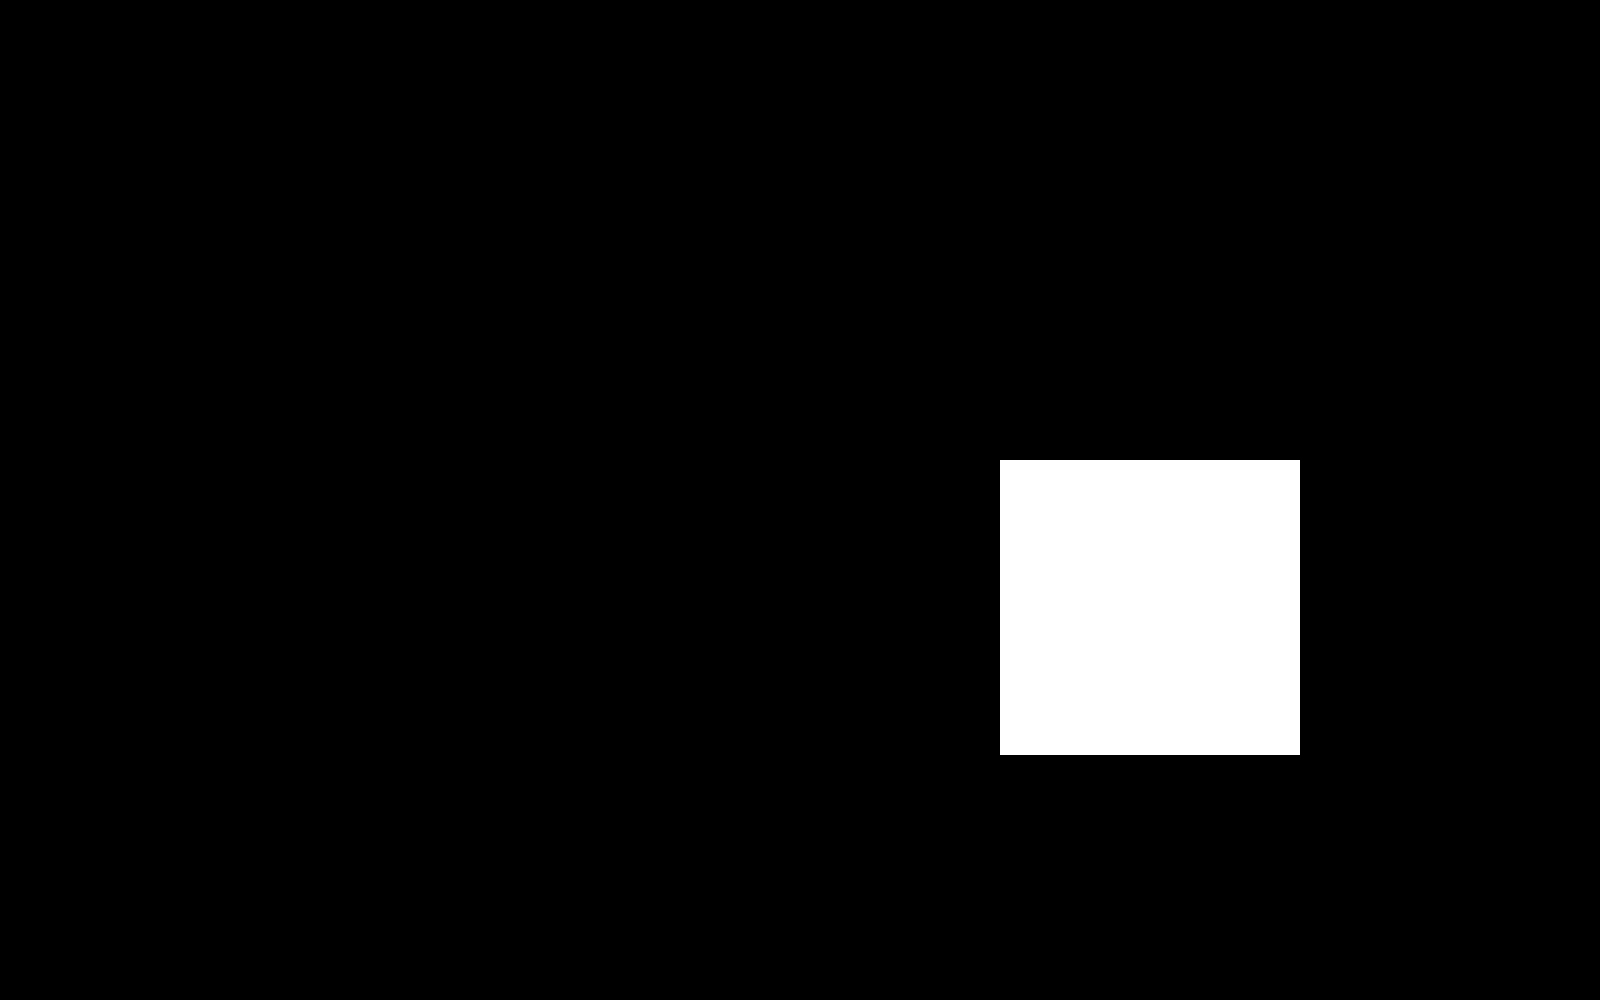

In [8]:
blend_images(8)